# UNET Island Detection Test

This notebook will be a proof of concept of how useful UNETS are for the problem of island detection in video microscopy.

We will train a custom UNet

# Setup

### Installing packages

In [ ]:
!pip install pims

     |████████████████████████████████| 92kB 4.5MB/s 
  Created wheel for pims: filename=PIMS-0.5-cp36-none-any.whl size=84329 sha256=2c6034960493df2ff7ee596e6b106c252b6707411a6a0c539b1e5f8a1e4973f1
  Stored in directory: /root/.cache/pip/wheels/0e/0a/14/4c33a4cc1b9158e57329a38e8e3e03901ed24060eb322d5462
Successfully built pims


### Mounting Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


(Important: Make sure your google drive has a folder named UNETDefectTest before running)

In [ ]:
%cd "/content/drive/My Drive/LabCode/ColabNotebookData/CustomUNetDefectTest/"
#!pip install -r "requirements.txt"

/content/drive/My Drive/LabCode/ColabNotebookData/CustomUNetDefectTest


### Generating Defects

This branch generates the defect images.

In [ ]:
import os
import sys
import imp
import shutil

def simulate(runName, numImages, imageDims, maxDefects, minDefects, decrossMin, decrossMax):
    """Generate images and data of simulated smectic films with defects for training.

    Args:
        runName (str, unless told otherwise as 'run DD/MM/YY/hh/mm/ss'): the name of the directory the output of this function will be stored in. If it already exists, nothing will be overwritten
        numImages (int, optional): number of images the function should create
        imageDims (list, optional): dimensions of the images to be simulated as [x, y] where both are int
        maxDefects (int, optional): maximum number of defects an image can have
        minDefects (int, optional): minimum number of defects an image can have
        decrossMin (float, optional): minimum "Hourglass-ness" of a defect ADAM LOOK HERE
        decrossMax (float, optional): maximum "Hourglass-ness" of a defect ADAM LOOK HERE

    Writes:
        *_defect*.dat: Writes defect location data files to ../sett2/<runName>
        *_out*.dat: Writes spin data files to ../sett2/<runName>
        *_defect*.jpg: Writes images of the schlieren texture to ../sett2/<runName>
        *_defect*.txt: *defect*.dat converted to txt written to ../sett2/<runName>
        *_defect*SIMMARKED.jpg: Writes images of schlieren texture with annotated defects to ../sett2/<runName>/SIMMARKED
        *_defect*.xml: Writes defect bounding boxes in .xml format for YOLO training to ../sett2/<runName>/out

    Note:
        Creates *out*.dat files storing spins of individual molecules, *defect*.dat with defect locations marked.
        Also creates .jpg files containing the schlieren texture, the same images with annotated defect locaions and
        .xml files with defect locations to be used by YOLO.
    """

    simString = 'simulations/randomDefects/runSim.py' # Path containing the runSim module.
    functionName = 'runSim' # Name of function being instantiated in runSim.

    reset = os.getcwd()

    home = os.getcwd() # Home directory of sett2.

    print("Running Simulation")

    path, exFile = os.path.split(simString) # Splitting path and runSim.py.
    fullPath = os.path.join(home, path) # Creating full path for runSim.py.
    sys.path.append(fullPath) # Adding simulation directory to PATH.
    os.chdir(fullPath) # Changing directory to simulation.

    # Importing the module runSim.
    sim = imp.load_source('packages', exFile)

    # Importing the function in runSim.
    runSimulation = getattr(sim,functionName)

    # Calling function to simulate.
    runSimulation(home, runName, numImages, imageDims, maxDefects, minDefects, decrossMin, decrossMax)

    # Changing directory back.
    os.chdir(reset)

### Importing packages

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torchvision import transforms
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pims
import pathlib
import torch.optim as optim
from torch.autograd import Variable
import skimage as skm
import glob

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)2768896/45929032 bytes (6.0%)6365184/45929032 bytes (13.9%)10051584/45929032 bytes (21.9%)13402112/45929032 bytes (29.2%)16785408/45929032 bytes (36.5%)20299776/45929032 bytes (44.2%)23846912/45929032 bytes (51.9%)27492352/45929032 bytes (59.9%)30777344/45929032 bytes (67.0%)34422784/45929032 bytes (74.9%)38150144/45929032 bytes (83.1%)41607168/45929032 bytes (90.6%)

# Section 1: Generating Data
1. Island data needs to be generated from training (ravin's program)
2. Island data needs to be pre-segmented (all islands need to be labelled)
3. We need to decide on the best way to label this (I think 0 for not an island, and 1 for an island will be fine)

### Creating images and output masks (Ignore the error at the end)

In [ ]:
import time

runName = "/UNet"
numImages = 500 # Number of images to simulate.
imageDims = [84, 84] # Resolution of image in [x, y].
maxDefects = 25 # Maximum defects per image.
minDefects = 24 # Minimum defects per image.
decrossMin = 50 # Maximum 'hourglassness'
decrossMax = 50 # Minimum 'hourgrassness'

startTime = time.time()
simulate(runName, numImages, imageDims, maxDefects, minDefects, decrossMin, decrossMax)
endTime = time.time()

print("Simulation time for", repr(numImages), "images (in seconds):", repr(endTime - startTime))

In [ ]:
%cd ../..

In [ ]:
!cp -r "/content/drive/My Drive/LabCode/ColabNotebookData/CustomUNetDefectTest/simulations/randomDefects/dataFolder/run2020831_152020" "/content/drive/My Drive/LabCode/ColabNotebookData/CustomUNetDefectTest/data/"

In [ ]:
def pad(mask, val):
  for i in np.where(mask == val)[0]:
    for j in np.where(mask[i] == val)[0]:
      if i > 0 and j > 0 and i < len(mask) - 1 and j < len(mask[0]) - 1:
        mask[i-1][j-1] = val
        mask[i-1][j] = val
        mask[i-1][j+1] = val

        mask[i][j-1] = val
        mask[i][j] = val
        mask[i][j+1] = val

        mask[i+1][j-1] = val
        mask[i+1][j] = val
        mask[i+1][j+1] = val
  return mask

In [ ]:
print(len(glob.glob("./data/data/defect*.dat")))
for dat in glob.glob("./data/data/defect*.dat"):
  name = dat[18:][:-4]
  with open(dat, 'r') as f:
    d = f.readlines()
    array = []
    for i in d:
      k = i.rstrip().split(" ")
      row = []
      for l in k:
        row.append(int(abs(float(l))))
      array.append(row)
      arrayNp = pad(np.asarray(array), 1)
    np.savetxt("./data/im/image"+name+".txt", arrayNp)

### Organizing Data into islandDataset

In [ ]:
class defectDataset(Dataset):
  def __init__(self):

    self.frames = pims.ImageSequence('./data/im/*.bmp')
    self.names = pd.Series(self.frames._filepaths)
    self.names = self.names.str.replace('bmp', 'txt')
    self.to_tensor = transforms.ToTensor()

  def __len__(self):
    return len(self.frames)

  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx.tolist()
    label = self.to_tensor(np.genfromtxt(self.names.iloc[idx])).to(dtype=torch.float32)
    sample = [self.to_tensor(self.frames[idx]/255).to(dtype=torch.float32), label]
    return sample

### Setup test-train split

In [ ]:
#setup test train split

islD = defectDataset()
train_size = int(.8*len(islD))
test_size = len(islD)-train_size

bs = 16 #(batch size)

train_dataset, test_dataset = torch.utils.data.random_split(islD, [train_size, test_size])
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = bs, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = bs, shuffle = False)

#we then load this dataset into a dataloader-- this is what will feed the gpu. Gpu's are hungry
#so we want to feed them as much as possible. the dataloader will spit out a list that holds multiple
#images and labels, which can be processed in parallel in the gpu. Generally, you want the batch size to
#be a number big enough to use up all the gpu's memory, so no resource goes to waste.

# the axes are:
# batch, rgb, height, width

imgs, labels = next(iter(train_loader))
print(imgs.size())
print(labels.size())

torch.Size([16, 1, 84, 84])
torch.Size([16, 1, 84, 84])


# Section 2: Training a Simple UNET
1. Get a simple CNN trained (to test out and debug pytorch)
2. Figure out how the upsampling/padding will work for UNET
3. Build a simple 'downsampler' CNN
4. Add on to build an 'upsampler' side
5. Train UNET on *data*

### Defining the Unet

In [ ]:
def double_conv(in_c, out_c):

	conv = nn.Sequential(
		nn.Conv2d(in_c, out_c, kernel_size = 3),
		nn.ReLU(inplace = True),
		nn.Conv2d(out_c, out_c, kernel_size = 3),
		nn.ReLU(inplace = True)
	)

	return conv

def crop_img(tensor, target_tensor):

	target_size = target_tensor.size()[2]
	tensor_size = tensor.size()[2]

	delta = tensor_size - target_size
	delta = delta // 2

	return tensor[:, :, delta:tensor_size - delta, delta:tensor_size - delta]

class UNetOld(nn.Module):

	def __init__(self):

		super(UNetOld, self).__init__()

		self.max_pool_2x2 = nn.MaxPool2d(kernel_size = 2, stride = 2)

		self.down_conv_1 = double_conv(1, 64) # Only 1 channel at the moment
		self.down_conv_2 = double_conv(64, 128)
		self.down_conv_3 = double_conv(128, 256)
	
		self.up_trans_3 = nn.ConvTranspose2d(
			in_channels = 256,
			out_channels = 128,
			kernel_size = 2,
			stride = 2
		)

		self.up_conv_3 = double_conv(256, 128)

		self.up_trans_4 = nn.ConvTranspose2d(
			in_channels = 128,
			out_channels = 64,
			kernel_size = 2,
			stride = 2
		)

		self.up_conv_4 = double_conv(128, 64)

		self.out = nn.Conv2d(
			in_channels = 64,
			out_channels = 1,
			kernel_size = 1
		)

	def forward(self, image):

		# bs, c, h, w
		# Encoder
		x1 = self.down_conv_1(image)#
		x3 = self.max_pool_2x2(x1)

		x3 = self.down_conv_2(x3)#
		x5 = self.max_pool_2x2(x3)

		x5 = self.down_conv_3(x5)#

		# Decoder

		x = self.up_trans_3(x5)
		y = crop_img(x3, x)
		x = self.up_conv_3(torch.cat([x, y], 1))

		x = self.up_trans_4(x)
		y = crop_img(x1, x)
		x = self.up_conv_4(torch.cat([x, y], 1))
	
		x1, x3, x5, y = None, None, None, None,

		x = self.out(x)
		return x

### Setting up uModel and viewing untrained output

torch.Size([16, 1, 44, 44])


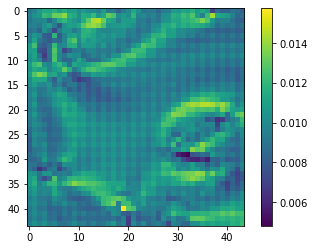

In [ ]:
uModel = UNetOld()
images, labels = next(iter(train_loader))

output = uModel(images)

print(output.shape)

fig, ax = plt.subplots()
a = ax.imshow(output[0][0].detach().numpy())
plt.colorbar(a)

### Defining Training Loop

In [ ]:
import datetime

device = (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))
print(f"Training on device {device}.")

losses = []
loss_fn = nn.BCEWithLogitsLoss()
lr = 1
model = uModel.to(device)
optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay = .0005, momentum = .9)
def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    tlosses = []
    for epoch in range(1, n_epochs + 1):  # <2>
        loss_train = 0.0
        for imgs, labels in train_loader:  # <3>
            imgs = imgs.to(device=device)
            labels = labels.to(device=device)
            outputs = model(imgs)  # <4>

            loss = loss_fn(outputs, crop_img(labels, outputs))  # <5>
            optimizer.zero_grad()  # <6>

            loss.backward()  # <7>

            optimizer.step()  # <8>

            loss_train += loss.item()  # <9>

        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}, std{} , teststd {} '.format(
                datetime.datetime.now(), epoch, loss_train/len(train_loader), outputs.std(), labels.float().std()))
            tlosses.append(loss_train/len(train_loader))
    return tlosses

Training on device cuda.


Start Training

In [ ]:
losses.append(training_loop(100, optimizer, model, loss_fn, train_loader))

2020-09-05 18:22:30.714033 Epoch 1, Training loss 0.391667560338974, std0.0 , teststd 0.3335016369819641 
2020-09-05 18:23:05.568484 Epoch 10, Training loss 0.3912138366699219, std0.0 , teststd 0.34077689051628113 
2020-09-05 18:23:44.705716 Epoch 20, Training loss 0.3910385930538178, std0.0 , teststd 0.33524471521377563 
2020-09-05 18:24:23.467667 Epoch 30, Training loss 0.3910615682601929, std0.0 , teststd 0.3261655867099762 
2020-09-05 18:25:02.254148 Epoch 40, Training loss 0.39116005420684813, std0.0 , teststd 0.33830657601356506 
2020-09-05 18:25:41.066690 Epoch 50, Training loss 0.3911268973350525, std0.0 , teststd 0.32572251558303833 
2020-09-05 18:26:20.027903 Epoch 60, Training loss 0.39115182757377626, std0.0 , teststd 0.32250747084617615 
2020-09-05 18:26:58.742497 Epoch 70, Training loss 0.39141842365264895, std0.0 , teststd 0.32942017912864685 
2020-09-05 18:27:38.329887 Epoch 80, Training loss 0.39116085052490235, std0.0 , teststd 0.3254024386405945 
2020-09-05 18:28:17.

In [ ]:
PATH = './unetFasttt.pth'
torch.save(uModel.state_dict(), PATH)

In [ ]:
PATH = './unetFast.pth'
uModel = UNetOld()
uModel.to(device)
uModel.load_state_dict(torch.load(PATH))

<All keys matched successfully>

### View output after training

In [ ]:
images, labels = next(iter(train_loader))
output = uModel(images.to(device))

print(output.shape)

torch.Size([16, 1, 44, 44])


In [ ]:
def cropTen(a, b): #a<=b
  sa1, sa2 = len(a), len(a[0])
  sb1, sb2 = len(b), len(b[0])
  d1, d2 = (sb1-sa1)//2, (sb2-sa2)//2
  return b[d1:sb1-d1, d2:sb2-d2]

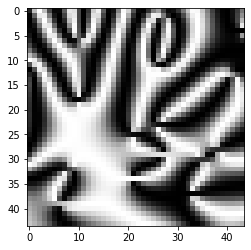

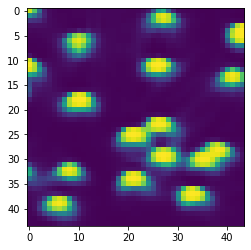

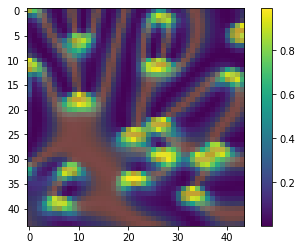

In [ ]:
fig1, ax1 = plt.subplots()
fig2, ax2 = plt.subplots()
fig3, ax3 = plt.subplots()

image = images[0][0].numpy()
outputIm = torch.sigmoid(output[0][0]).to("cpu").detach().numpy()

image = cropTen(outputIm, image)

masked = np.ma.masked_where(outputIm == 0, outputIm)

a = ax1.imshow(image, 'gray')
b = ax2.imshow(outputIm)
ax3.imshow(image)
ax3.imshow(masked, interpolation='none', alpha=0.7)
plt.colorbar(b)

### Testing Images

/usr/local/lib/python3.6/dist-packages/torchvision/transforms/transforms.py:257: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")


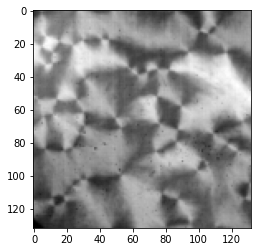

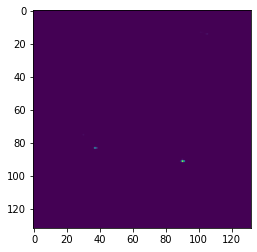

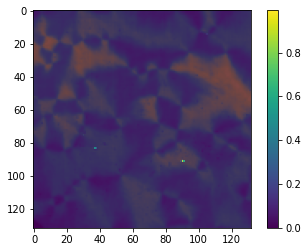

In [ ]:
from PIL import Image

imsize = 2*(2*(84+2)+2)
loader = transforms.Compose([transforms.Scale(imsize), transforms.CenterCrop((imsize,imsize)), transforms.ToTensor()])

def image_loader(image_name):
    """load image, returns cuda tensor"""
    image = Image.open(image_name)
    image = loader(image).float()
    image = Variable(image, requires_grad=True)
    image = image.unsqueeze(0)  #this is for VGG, may not be needed for ResNet
    return image.to(device)  #assumes that you're using GPU

testImage = image_loader("./testImages/r3_1000.tif")
testOutput = torch.sigmoid(10*uModel(testImage)[0][0]).to("cpu").detach().numpy()

fig1, ax1 = plt.subplots()
fig2, ax2 = plt.subplots()
fig3, ax3 = plt.subplots()

testImage = cropTen(testOutput, testImage[0][0].to("cpu").detach().numpy())

masked = np.ma.masked_where(testOutput == 1, testOutput)

a = ax1.imshow(testImage, 'gray')
b = ax2.imshow(testOutput)
ax3.imshow(testImage)
ax3.imshow(testOutput, interpolation='none', alpha=0.7)
plt.colorbar(b)